In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers,models
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
import zipfile
path='/content/fer2013.csv.zip'
with zipfile.ZipFile(path,'r') as z:
  z.extractall('/content/')

In [ ]:
data=pd.read_csv('/content/fer2013.csv')
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [ ]:
def convert_pixels(pixel_str):
    pixels = np.array(pixel_str.split(), dtype='float32')
    return pixels.reshape(48, 48, 1) / 255.0

In [ ]:
X = np.array([convert_pixels(p) for p in data['pixels']])
y = np.array(data['emotion'])

In [ ]:
train_idx = data['Usage'] == "Training"
val_idx = data['Usage'] == "PublicTest"

X_train = X[train_idx]
y_train = y[train_idx]

X_val = X[val_idx]
y_val = y[val_idx]

In [ ]:
num_classes = 7   # FER2013 has 7 emotions

y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)

In [ ]:
model = models.Sequential([
    layers.Input(shape=(48, 48, 1)),

    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),

    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,275,271 (4.86 MB)

 Trainable params: 1,274,823 (4.86 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
checkpoint = ModelCheckpoint(
    "best_emotion_model.h5", monitor='val_accuracy',
    save_best_only=True, verbose=1
)

early = EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=40,
    batch_size=64,
    callbacks=[checkpoint, early]
)

Epoch 1/40
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.2695 - loss: 2.0987
Epoch 1: val_accuracy improved from -inf to 0.32600, saving model to best_emotion_model.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 192s 419ms/step - accuracy: 0.2696 - loss: 2.0980 - val_accuracy: 0.3260 - val_loss: 1.6758
Epoch 2/40
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - accuracy: 0.3865 - loss: 1.5507
Epoch 2: val_accuracy improved from 0.32600 to 0.41989, saving model to best_emotion_model.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 197s 410ms/step - accuracy: 0.3866 - loss: 1.5507 - val_accuracy: 0.4199 - val_loss: 1.5058
Epoch 3/40
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.4326 - loss: 1.4517
Epoch 3: val_accuracy improved from 0.41989 to 0.48649, saving model to best_emotion_model.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 180s 401ms/step - accuracy: 0.4327 - loss: 1.4517 - val_accuracy: 0.4865 - val_loss: 1.3690
Epoch 4/40
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.4610 - loss: 1.3833
Epoch 4: val_accuracy did not improve from 0.48649
449/449 ━━━━━━━━━━━━━━━━━━━━ 204s 405ms/step - accuracy: 0.4610 - loss: 1.3833 - val_accuracy: 0.4472 - val_loss: 1.4278
Epoch 5/40
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - accuracy: 0.4850 - loss: 1.3142
Epoch 5: val_accuracy improved from 0.48649 to 0.50850, saving model to best_emotion_model.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 206s 414ms/step - accuracy: 0.4851 - loss: 1.3141 - val_accuracy: 0.5085 - val_loss: 1.2691
Epoch 6/40
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.5087 - loss: 1.2488
Epoch 6: val_accuracy did not improve from 0.50850
449/449 ━━━━━━━━━━━━━━━━━━━━ 202s 414ms/step - accuracy: 0.5087 - loss: 1.2488 - val_accuracy: 0.4957 - val_loss: 1.3106
Epoch 7/40
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - accuracy: 0.5379 - loss: 1.2031
Epoch 7: val_accuracy improved from 0.50850 to 0.53413, saving model to best_emotion_model.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 175s 389ms/step - accuracy: 0.5379 - loss: 1.2031 - val_accuracy: 0.5341 - val_loss: 1.2236
Epoch 8/40
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.5546 - loss: 1.1376
Epoch 8: val_accuracy did not improve from 0.53413
449/449 ━━━━━━━━━━━━━━━━━━━━ 203s 392ms/step - accuracy: 0.5546 - loss: 1.1376 - val_accuracy: 0.5238 - val_loss: 1.2476
Epoch 9/40
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.5838 - loss: 1.0798
Epoch 9: val_accuracy did not improve from 0.53413
449/449 ━━━━━━━━━━━━━━━━━━━━ 177s 394ms/step - accuracy: 0.5838 - loss: 1.0799 - val_accuracy: 0.4862 - val_loss: 1.4206
Epoch 10/40
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.6065 - loss: 1.0132
Epoch 10: val_accuracy did not improve from 0.53413
449/449 ━━━━━━━━━━━━━━━━━━━━ 201s 392ms/step - accuracy: 0.6065 - loss: 1.0133 - val_accuracy: 0.4765 - val_loss: 1.6335
Epoch 11/40
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.6264 - loss: 0.9527
Epoch 11

449/449 ━━━━━━━━━━━━━━━━━━━━ 200s 387ms/step - accuracy: 0.6264 - loss: 0.9527 - val_accuracy: 0.5545 - val_loss: 1.2235
Epoch 12/40
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - accuracy: 0.6582 - loss: 0.8924
Epoch 12: val_accuracy improved from 0.55447 to 0.55614, saving model to best_emotion_model.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 173s 386ms/step - accuracy: 0.6581 - loss: 0.8924 - val_accuracy: 0.5561 - val_loss: 1.2370
Epoch 13/40
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.6797 - loss: 0.8206
Epoch 13: val_accuracy improved from 0.55614 to 0.56032, saving model to best_emotion_model.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 216s 417ms/step - accuracy: 0.6797 - loss: 0.8206 - val_accuracy: 0.5603 - val_loss: 1.2606
Epoch 14/40
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.6896 - loss: 0.7958
Epoch 14: val_accuracy improved from 0.56032 to 0.56144, saving model to best_emotion_model.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 197s 406ms/step - accuracy: 0.6896 - loss: 0.7959 - val_accuracy: 0.5614 - val_loss: 1.3379
Epoch 15/40
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.7078 - loss: 0.7484
Epoch 15: val_accuracy did not improve from 0.56144
449/449 ━━━━━━━━━━━━━━━━━━━━ 180s 401ms/step - accuracy: 0.7078 - loss: 0.7484 - val_accuracy: 0.5316 - val_loss: 1.3636
Epoch 16/40
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.7284 - loss: 0.6973
Epoch 16: val_accuracy improved from 0.56144 to 0.56673, saving model to best_emotion_model.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 175s 389ms/step - accuracy: 0.7284 - loss: 0.6974 - val_accuracy: 0.5667 - val_loss: 1.3645


In [ ]:
model.save("emotion_model.h5")

In [ ]:
model.save("emotion_model.keras")

In [ ]:
from tensorflow.keras.models import load_model

emotion_model = load_model("emotion_model.h5")
print("Model loaded successfully!")

Model loaded successfully!


In [ ]:
import cv2
import numpy as np

img = cv2.imread("/content/laughping child.jpg")

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

face_resized = cv2.resize(gray, (48, 48))

face_norm = face_resized / 255.0

face_input = np.expand_dims(face_norm, axis=(0, -1))
pred = emotion_model.predict(face_input)
emotion_index = np.argmax(pred)
print("Emotion index:", emotion_index)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
Emotion index: 5


In [ ]:
emotion_labels = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

print("Predicted Emotion:", emotion_labels[emotion_index])

Predicted Emotion: Surprise


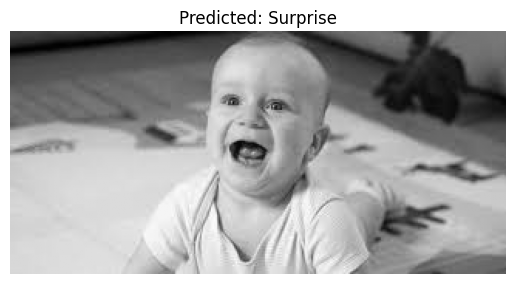

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(gray, cmap='gray')
plt.title(f"Predicted: {emotion_labels[emotion_index]}")
plt.axis("off")
plt.show()

In [ ]:
import tensorflow as tf
tf.keras.models.save_model(
    model,
    "emotion_model_legacy.h5",
    save_format="h5"
)

In [ ]:
from google.colab import files
files.download("emotion_model_legacy.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>